In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# PARÂMETROS

In [2]:
area = 4317 # original: 4317
delta = 0.10 # percentual do consumo [%]

# DADOS DE CONSUMO

In [3]:
# Leitura e tratamento dos dados

dados_consumo=pd.read_csv("dados_consumo.csv", sep=";", header=None)
dados_consumo.rename({0:'Date',
           1:'Month',
           2:'Cons'},axis=1,inplace=True)

dados_consumo.index=pd.to_datetime(dados_consumo['Date'])
dados_consumo.drop('Date',axis=1,inplace=True)
dados_consumo.drop('Month',axis=1,inplace=True)
dados_consumo['Cons']=dados_consumo['Cons'].str.replace(',','.')
dados_consumo['Cons']=dados_consumo['Cons'].astype(float)
dados_consumo=dados_consumo.resample('1h').sum()
dados_consumo['Cons']=dados_consumo['Cons'].resample('1h').sum()

dados_consumo.loc[dados_consumo.index=='2018-02-28','Cons'] = dados_consumo['Cons'].mean() # outlier

# DADOS DE IRRADIAÇÃO SOLAR

In [4]:
# Leitura e tratamento dos dados

dados_irradiacao=pd.read_csv("dados_irradiacao.csv", sep=";")
dados_irradiacao['Irradiacao']=dados_irradiacao['Irradiacao'].str.replace(',','.').astype(float)

In [5]:
# Função que calcular a energia gerada por PV

def PV_out(dados_irradiacao):
    dados_irradiacao['PV_Out']=dados_irradiacao['Irradiacao']*0.15*0.95*area
    return dados_irradiacao

Text(0, 0.5, 'Irradiation [kWh]')

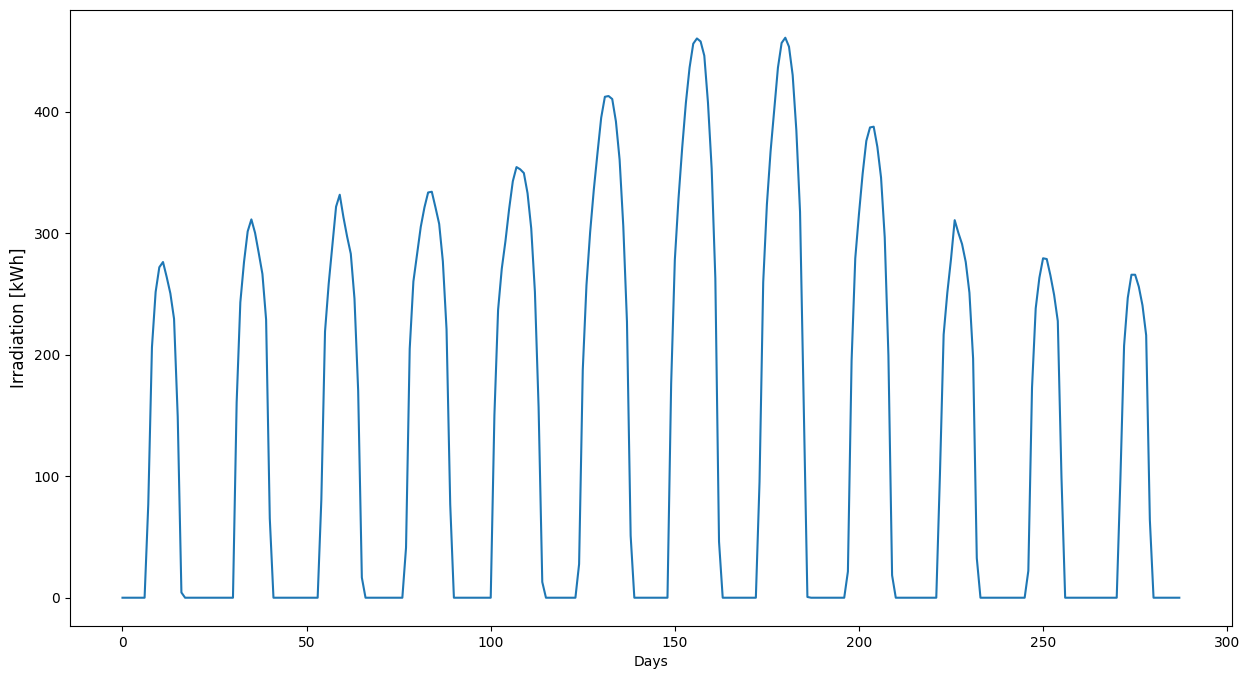

In [6]:
PV_out(dados_irradiacao)
dados_irradiacao['PV_Out'].plot()

plt.gcf().set_size_inches(15, 8) # tamanho da figura
plt.xlabel("Days")
plt.ylabel("Irradiation [kWh]",fontsize='large')

In [7]:
for i,row in dados_consumo.iterrows():
    dados_consumo.loc[i,'Irradiacao']=dados_irradiacao.loc[(dados_irradiacao.hora==i.hour) & (dados_irradiacao.mês==dados_irradiacao['mês'].unique()[i.month-1]),'Irradiacao'].values[0]
dados_consumo = PV_out(dados_consumo)

# SURPLUS

In [8]:
# Definindo o surplus de energia

dados_consumo['Cons'] = dados_consumo['Cons']*delta # variando delta, conseguimos 'brincar' com valor do consumo
dados_consumo['Surplus'] = dados_consumo['PV_Out'] - dados_consumo['Cons']

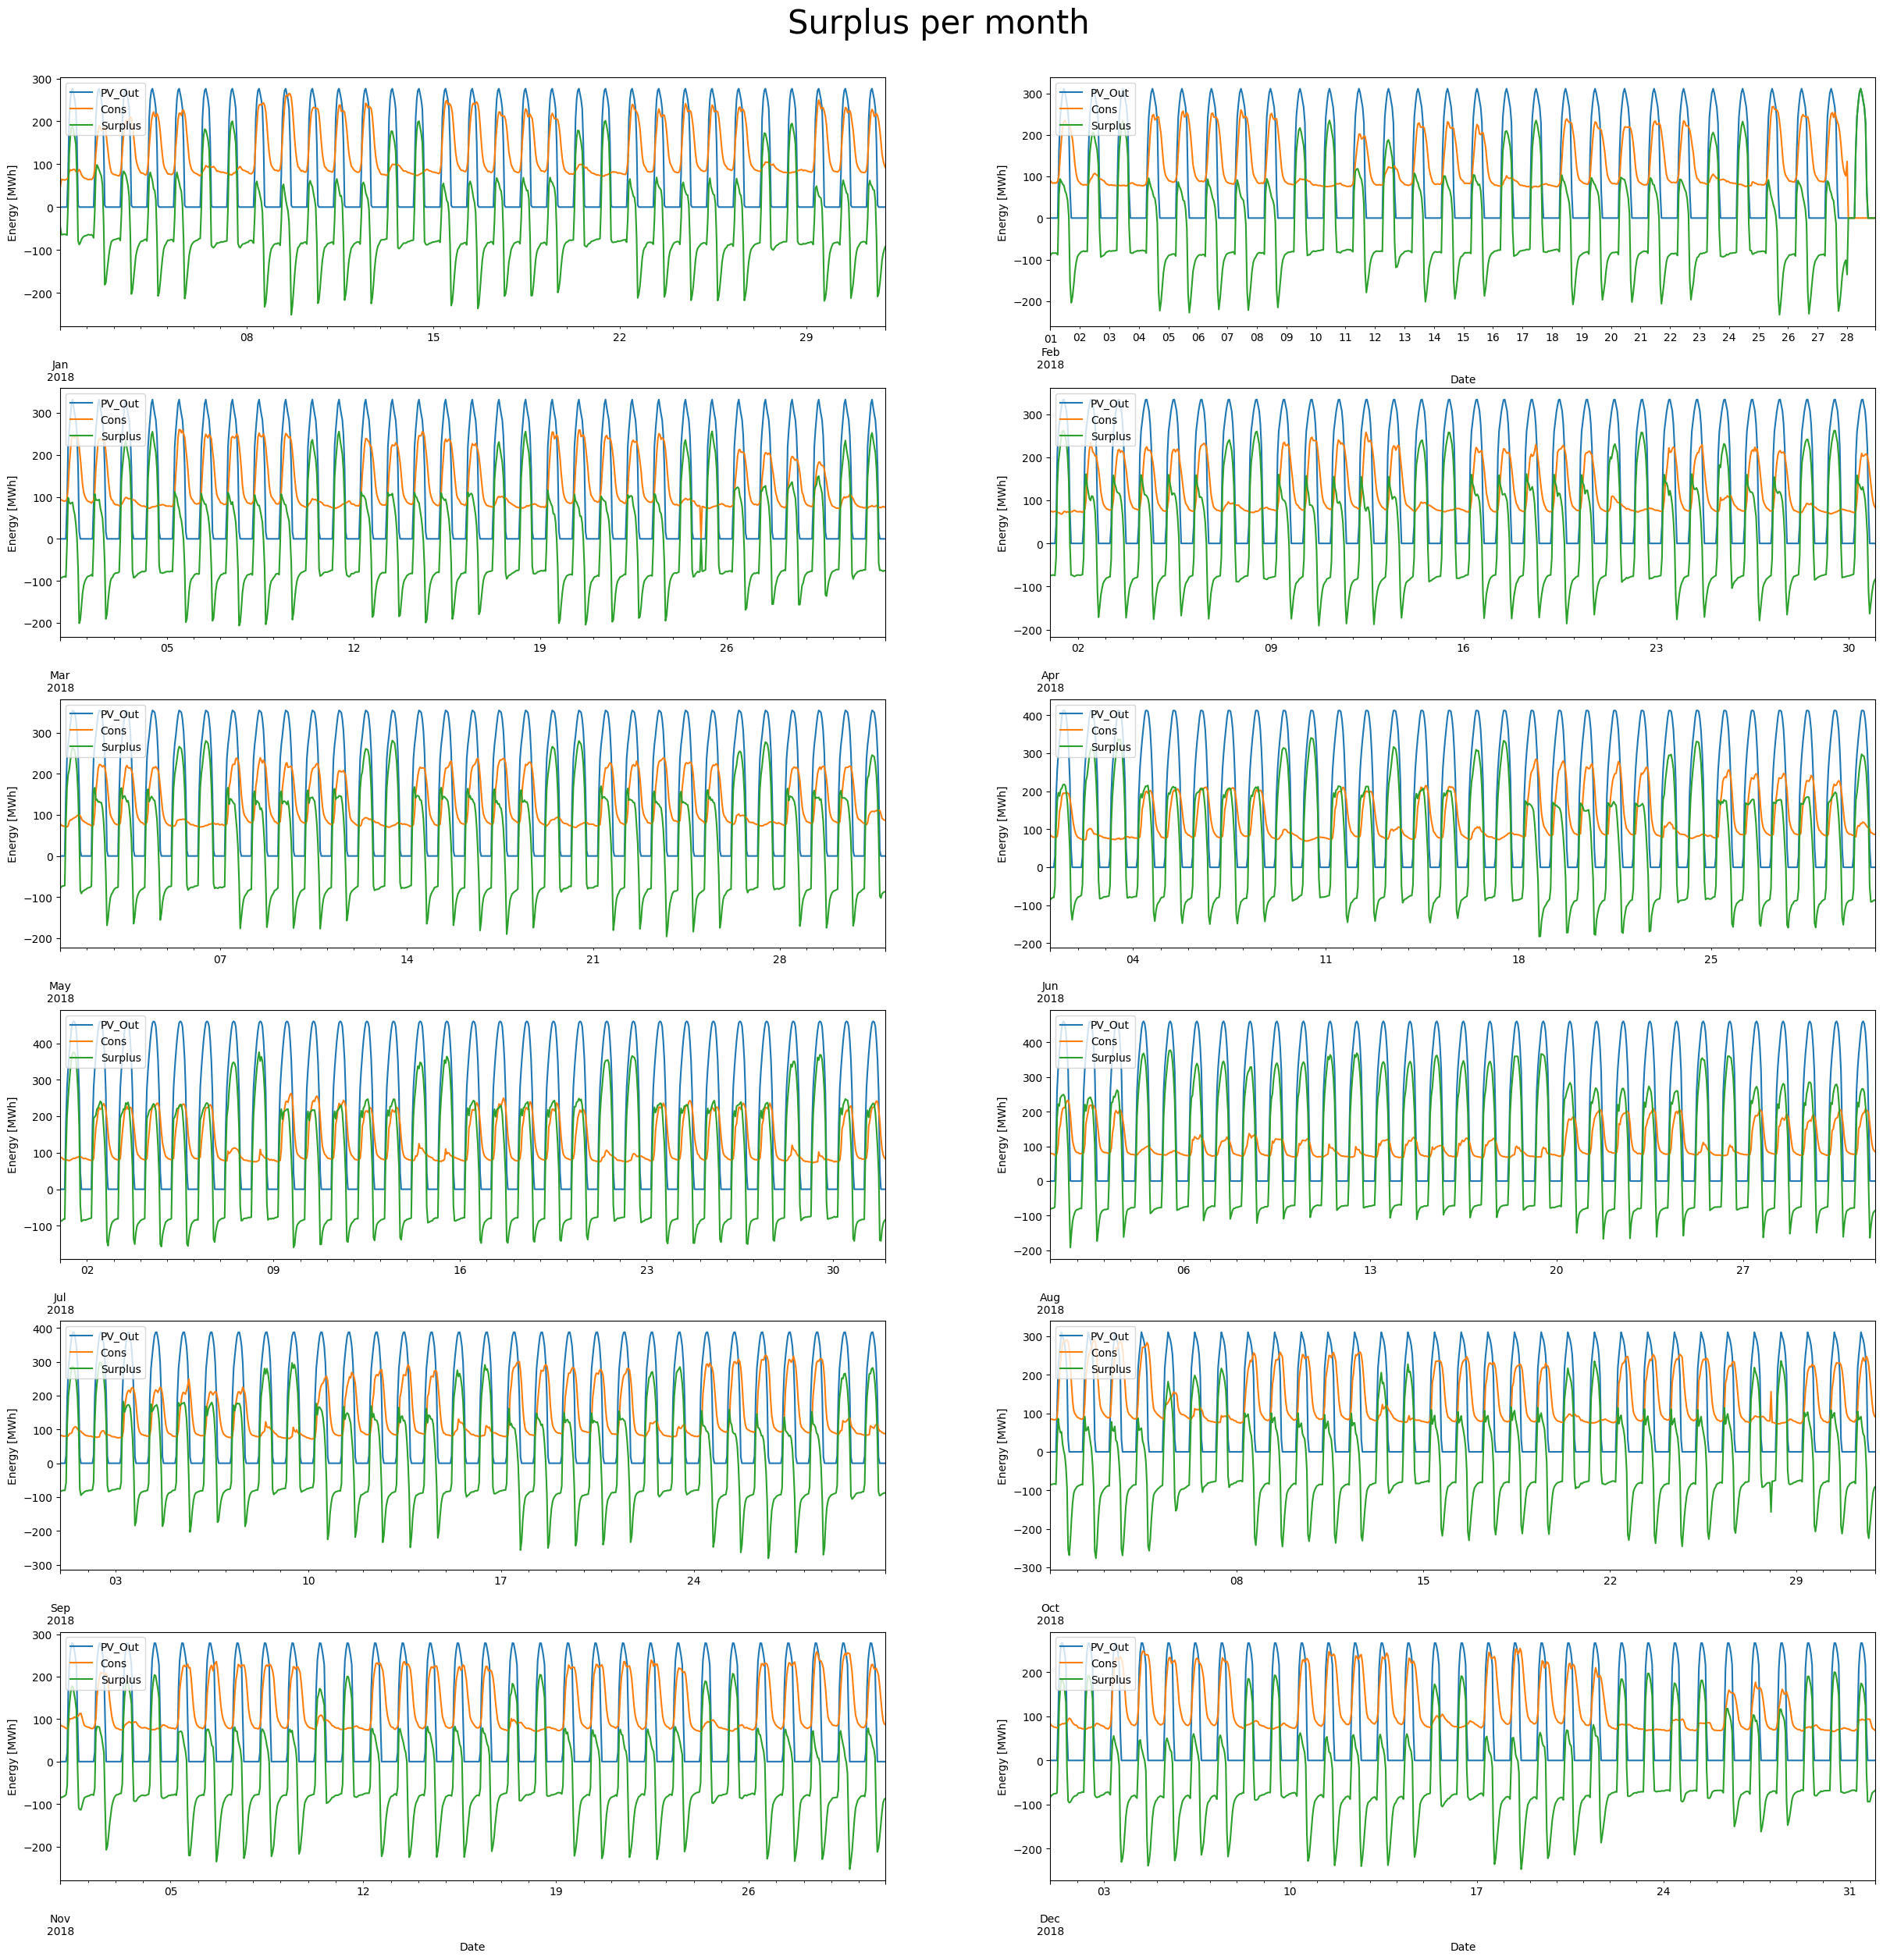

In [9]:
# Gráficos do surplus

plt.figure(figsize=(30, 30))
plt.subplots_adjust(hspace=0.25)
plt.suptitle("Surplus per month", fontsize=30, y=0.91)

for n, i in enumerate(range(1,13)):
    ax = plt.subplot(6, 2, n + 1)
    dados_consumo[['PV_Out','Cons','Surplus']].loc[(dados_consumo.index.month==i)].plot(ax=ax, label="PV Output")
    plt.legend(loc="upper left")
    plt.ylabel("Energy [MWh]")

Text(0, 0.5, 'Energy [MWh]')

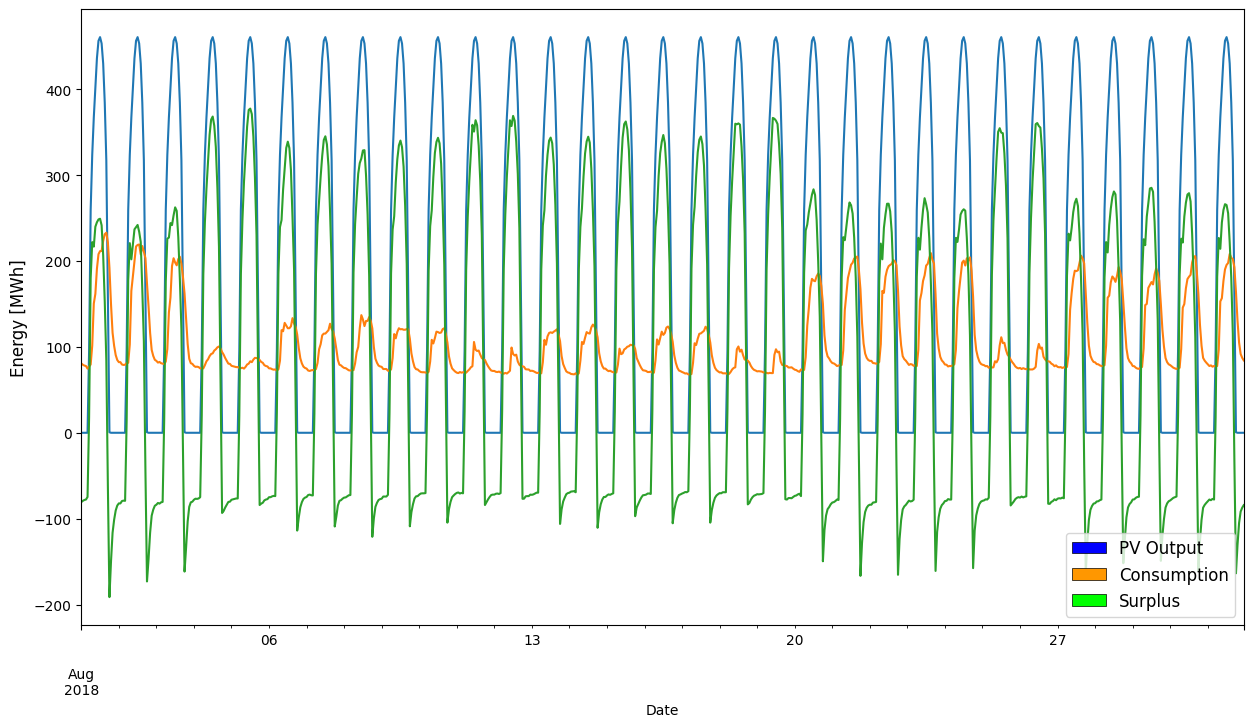

In [10]:
# plot de um mês -> mudar index.month == ' '
dados_consumo[['PV_Out','Cons','Surplus']].loc[(dados_consumo.index.month==8)].plot()
plt.gcf().set_size_inches(15, 8) # tamanho da figura

# legenda do gráfico
pv_out = mpatches.Patch(facecolor='#0000FF', label='PV Output', linewidth = 0.5, edgecolor = 'black')
cons = mpatches.Patch(facecolor='#ff9700', label = 'Consumption', linewidth = 0.5, edgecolor = 'black')
surplus = mpatches.Patch(facecolor='#00FF00', label = 'Surplus', linewidth = 0.5, edgecolor = 'black')
legend = plt.legend(handles=[pv_out,cons,surplus], loc=4, fontsize='large', fancybox=True)

# labels
plt.ylabel("Energy [MWh]",fontsize='large')

In [11]:
# Média mensal de surplus

for i in range(1,13):
    print(i, ":", dados_consumo['Surplus'].loc[(dados_consumo.index.month==i)].mean())

1 : -46.178927076612915
2 : -22.83113116123241
3 : -10.475716250000003
4 : 14.536867847222215
5 : 29.84449711021504
6 : 56.7880048611111
7 : 72.86005308803762
8 : 83.20311562499998
9 : 6.309642326388873
10 : -33.56698109879033
11 : -42.1200332638889
12 : -38.3065719186828


In [12]:
dados_consumo.to_csv('dados.csv')

# CÁLCULO DO PREÇO DE CARREGAMENTO

In [13]:
# taxas slow charger
fixed_slow = 0.03
time_slow = 0.02
energy_slow = 0.009

# taxas fast charger
fixed_fast = 0.038
time_fast = 0.077
energy_fast = 0.018

# preço tarifa horária
peak = 0.2816
mid = 0.1459
off = 0.0702

# taxa por consumo de energia
iec = 0.001

#IVA
iva = 0.23

In [14]:
#Variáveis do Veículo e carregamento

n = 0.5 # quantidade de carregamento da bateria
bateria = 82*n
tempo_slow = (11 * 60)*n
tempo_fast = ((3 * 60) + 45)*n

In [15]:
# Preços finais Slow Charging

preco_slow_peak = fixed_slow + (time_slow * tempo_slow) + (energy_slow*bateria) + (peak*bateria) + (iec*bateria)
preco_slow_peak = preco_slow_peak + preco_slow_peak*iva

preco_slow_mid = fixed_slow + (time_slow * tempo_slow) + (energy_slow*bateria) + (mid*bateria) + (iec*bateria)
preco_slow_mid = preco_slow_mid + preco_slow_mid*iva

preco_slow_off = fixed_slow + (time_slow * tempo_slow) + (energy_slow*bateria) + (off*bateria) + (iec*bateria)
preco_slow_off = preco_slow_off + preco_slow_off*iva

print('Preços (Slow Charging)\nPeak -',preco_slow_peak,'\nMid-peak -', preco_slow_mid, '\nOff-peak -' ,preco_slow_off)

Preços (Slow Charging)
Peak - 22.860288000000004 
Mid-peak - 16.016937000000002 
Off-peak - 12.199386


In [16]:
# Preços finais fast Charging

preco_fast_peak = fixed_fast + (time_fast * tempo_fast) + (energy_fast*bateria) + (peak*bateria) + (iec*bateria)
preco_fast_peak = preco_fast_peak + preco_fast_peak*iva

preco_fast_mid = fixed_fast + (time_fast * tempo_fast) + (energy_fast*bateria) + (mid*bateria) + (iec*bateria)
preco_fast_mid = preco_slow_mid + preco_slow_mid*iva

preco_fast_off = fixed_fast + (time_fast * tempo_fast) + (energy_fast*bateria) + (off*bateria) + (iec*bateria)
preco_fast_off = preco_fast_off + preco_fast_off*iva

print('Preços (Fast Charging)\nPeak -', preco_fast_peak,'\nMid-peak -',preco_fast_mid,'\nOff-peak -',preco_fast_off)

Preços (Fast Charging)
Peak - 25.860872999999998 
Mid-peak - 19.70083251 
Off-peak - 15.199971


In [17]:
# Preços finais Blockcharing

a = 0.75

print('Preços (Blockcharging - Slow charging)\nPeak -',preco_slow_peak*a,'\nMid-peak -',preco_slow_mid*a,'\nOff-peak -',preco_slow_off*a,'\n')
print('Preços (Blockcharging - Fast charging)\nPeak -',preco_fast_peak*a,'\nMid-peak -',preco_fast_mid*a,'\nOff-peak -',preco_fast_off*a)

Preços (Blockcharging - Slow charging)
Peak - 17.145216000000005 
Mid-peak - 12.012702750000003 
Off-peak - 9.1495395 

Preços (Blockcharging - Fast charging)
Peak - 19.39565475 
Mid-peak - 14.775624382500002 
Off-peak - 11.39997825
